In [1]:
from zipfile import ZipFile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from statsmodels.tsa.stattools import adfuller

gdp = pd.read_csv('data/GDP.csv')
unrate = pd.read_csv('data/UNRATE.csv')

In [2]:
#GDP

gdp['DATE'] = pd.to_datetime(gdp['DATE'], format = '%Y-%m')
gdp = gdp.set_index('DATE')

In [3]:
gdp = gdp.tail(n = 52)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


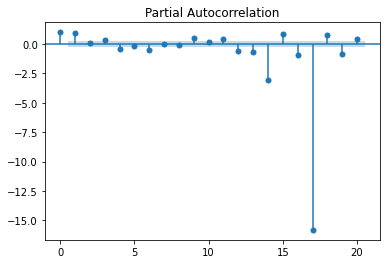

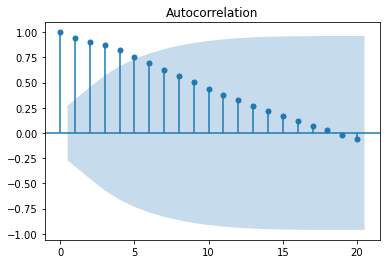

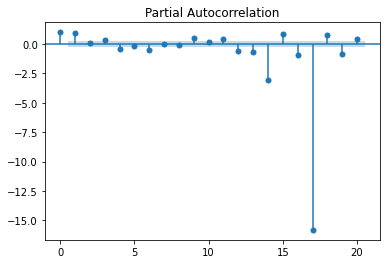

In [4]:
plot_acf(gdp, lags=20)
plot_pacf(gdp, lags=20)

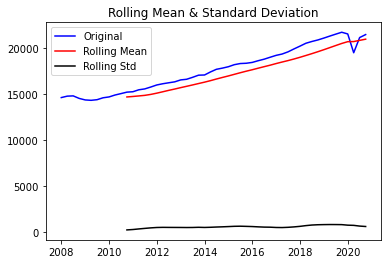

Results of Dickey-Fuller Test:


Test Statistic                  0.038828
p-value                         0.961628
#Lags Used                      2.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64

In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

test_stationarity(gdp) #Not stationary

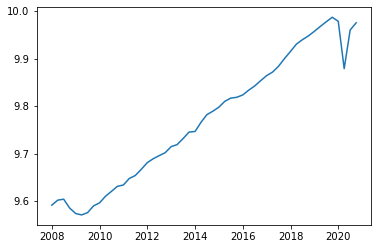

In [6]:
#Rolling average stationarity GDP

ts_log_gdp = np.log(gdp)
plt.plot(ts_log_gdp)

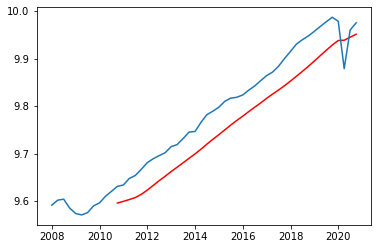

In [7]:
ts_smooth_gdp = ts_log_gdp.rolling(window = 12).mean()
plt.plot(ts_smooth_gdp, color = 'red')
plt.plot(ts_log_gdp)
plt.show()

In [8]:
# Case 1: No subtraction
no_sub_ts_gdp = ts_smooth_gdp
no_sub_ts_gdp.dropna(inplace = True)

# Case 2: Yes subtraction
sub_ts_gdp = ts_log_gdp - ts_smooth_gdp
sub_ts_gdp.dropna(inplace = True)

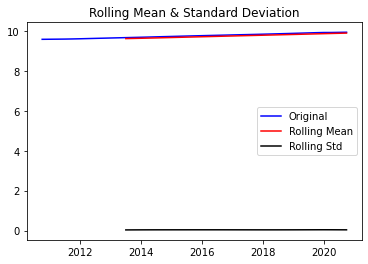

Results of Dickey-Fuller Test:


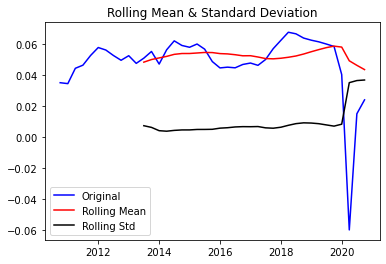

Results of Dickey-Fuller Test:


Test Statistic                 -3.065618
p-value                         0.029204
#Lags Used                      7.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

In [9]:
# Perform Dickey-Fuller on both
test_stationarity(no_sub_ts_gdp)
test_stationarity(sub_ts_gdp) #p-value = 0.03. Will aim for a lower value

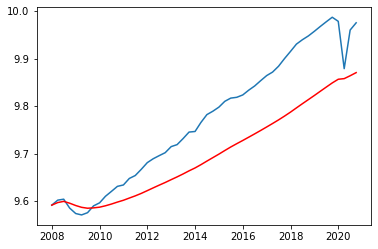

In [10]:
#Exponential weighing to test stationarity GDP

expwighted_avg_gdp = ts_log_gdp.ewm(halflife=12).mean()
plt.plot(ts_log_gdp)
plt.plot(expwighted_avg_gdp, color='red')

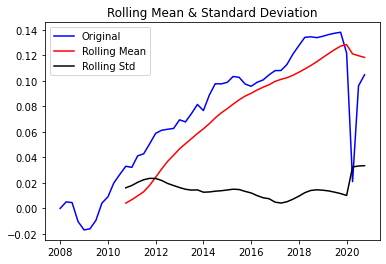

Results of Dickey-Fuller Test:


Test Statistic                 -1.516392
p-value                         0.525387
#Lags Used                      2.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64

In [11]:
exp_ts_diff_gdp = ts_log_gdp - expwighted_avg_gdp
test_stationarity(exp_ts_diff_gdp) #p-value = 0.52. Not stationary

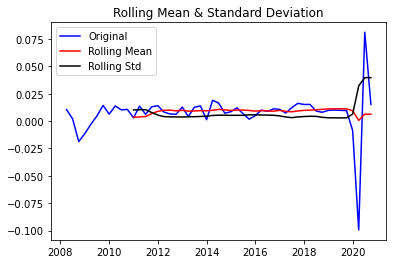

Results of Dickey-Fuller Test:


Test Statistic                -5.871830e+00
p-value                        3.226738e-07
#Lags Used                     1.000000e+00
Number of Observations Used    4.900000e+01
Critical Value (1%)           -3.571472e+00
Critical Value (5%)           -2.922629e+00
Critical Value (10%)          -2.599336e+00
dtype: float64

In [12]:
#Differencing for Stationarity GDP

ts_diff_gdp = ts_log_gdp - ts_log_gdp.shift()
ts_diff_gdp.dropna(inplace = True)

test_stationarity(ts_diff_gdp) # best result (p-value = 3.22 * 10^-7). Stationarity established.

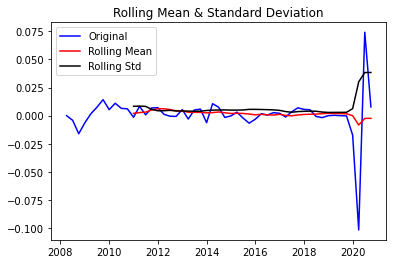

Results of Dickey-Fuller Test:


Test Statistic                -6.044590e+00
p-value                        1.321130e-07
#Lags Used                     1.000000e+00
Number of Observations Used    4.900000e+01
Critical Value (1%)           -3.571472e+00
Critical Value (5%)           -2.922629e+00
Critical Value (10%)          -2.599336e+00
dtype: float64

In [13]:
#Differencing + exponential weighing Olivia

ts_diff_exp_gdp = ts_diff_gdp  - ts_diff_gdp.ewm(halflife = 12).mean()
ts_diff_exp_gdp.dropna(inplace = True)
test_stationarity(ts_diff_exp_gdp) #p-value = 1.32 * 10^-7. Stationary, but better from differencing alone.

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OC

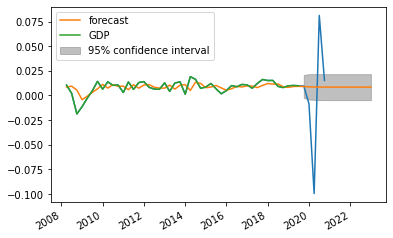

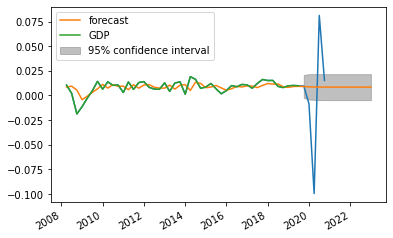

In [14]:
gdp_train = ts_diff_gdp.iloc[:-5]
gdp_test = ts_diff_gdp.iloc[-5:]

model = ARIMA(gdp_train, order=(1, 0, 0))
res = model.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(ts_diff_gdp)

res.plot_predict('2008', '2023', ax=ax)

In [15]:
#Unemployment Rate

unrate['DATE'] = pd.to_datetime(unrate['DATE'], format = '%Y-%m')
unrate = unrate.set_index('DATE')

In [16]:
unrate

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2020-11-01,6.7
2020-12-01,6.7
2021-01-01,6.3


In [17]:
#unrate = unrate.loc['1960-04-01':'2020-04-01']
#couldn't get data stationarity without taking the whole dataset for some reason

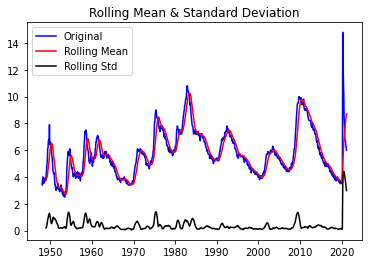

Results of Dickey-Fuller Test:


Test Statistic                  -4.001087
p-value                          0.001405
#Lags Used                       1.000000
Number of Observations Used    877.000000
Critical Value (1%)             -3.437828
Critical Value (5%)             -2.864841
Critical Value (10%)            -2.568528
dtype: float64

In [18]:
test_stationarity(unrate)#Stationary already. Checking to see if we can make it even better

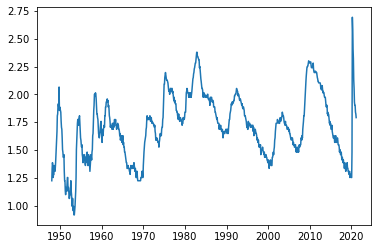

In [19]:
#Rolling average stationarity Unemployment Rate

ts_log_ur = np.log(unrate)
plt.plot(ts_log_ur)

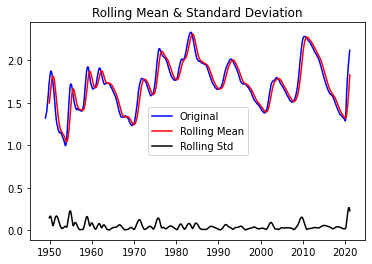

Results of Dickey-Fuller Test:


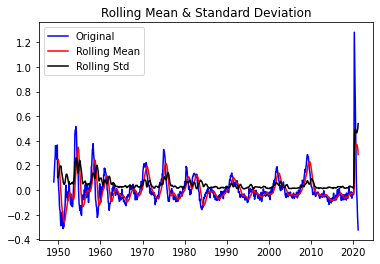

Results of Dickey-Fuller Test:


Test Statistic                -9.080417e+00
p-value                        4.070485e-15
#Lags Used                     8.000000e+00
Number of Observations Used    8.590000e+02
Critical Value (1%)           -3.437986e+00
Critical Value (5%)           -2.864911e+00
Critical Value (10%)          -2.568565e+00
dtype: float64

In [20]:
ts_smooth_ur = ts_log_ur.rolling(window = 12).mean()

# Case 1: No subtraction
no_sub_ts_ur = ts_smooth_ur
no_sub_ts_ur.dropna(inplace = True)

# Case 2: Yes subtraction
sub_ts_ur = ts_log_ur - ts_smooth_ur
sub_ts_ur.dropna(inplace = True)

test_stationarity(no_sub_ts_ur)
test_stationarity(sub_ts_ur)#p-value = 4.07 * 10^-15. Extremely stationary

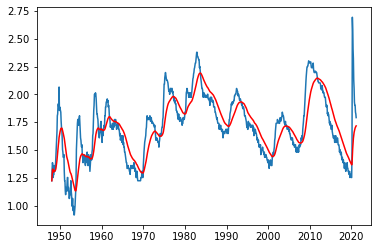

In [21]:
#Exponential weighing to test stationarity Unemployment Rate

expwighted_avg_ur = ts_log_ur.ewm(halflife=12).mean()
plt.plot(ts_log_ur)
plt.plot(expwighted_avg_ur, color='red')

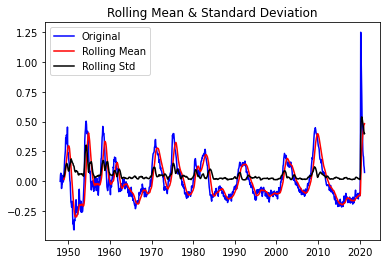

Results of Dickey-Fuller Test:


Test Statistic                  -5.222631
p-value                          0.000008
#Lags Used                      12.000000
Number of Observations Used    866.000000
Critical Value (1%)             -3.437924
Critical Value (5%)             -2.864883
Critical Value (10%)            -2.568550
dtype: float64

In [22]:
exp_ts_diff_ur = ts_log_ur - expwighted_avg_ur
test_stationarity(exp_ts_diff_ur) #p-value = 8 * 10^-6. Not as good as previous

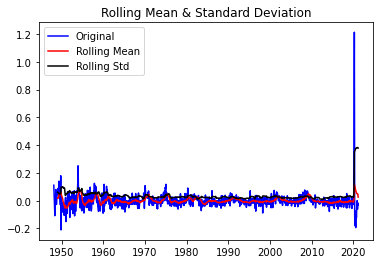

Results of Dickey-Fuller Test:


Test Statistic                 -26.019499
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    877.000000
Critical Value (1%)             -3.437828
Critical Value (5%)             -2.864841
Critical Value (10%)            -2.568528
dtype: float64

In [23]:
#Differencing for Stationarity Unemployment Rate

ts_diff_ur = ts_log_ur - ts_log_ur.shift()
ts_diff_ur.dropna(inplace = True)

test_stationarity(ts_diff_ur) # p-value = 0. Stationary.

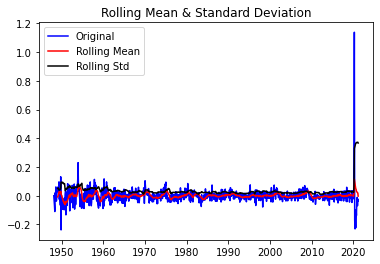

Results of Dickey-Fuller Test:


Test Statistic                -9.860893e+00
p-value                        4.236137e-17
#Lags Used                     1.100000e+01
Number of Observations Used    8.660000e+02
Critical Value (1%)           -3.437924e+00
Critical Value (5%)           -2.864883e+00
Critical Value (10%)          -2.568550e+00
dtype: float64

In [24]:
#Differencing + exponential weighing Unemployment Rate

ts_diff_exp_ur = ts_diff_ur  - ts_diff_ur.ewm(halflife = 12).mean()
ts_diff_exp_ur.dropna(inplace = True)
test_stationarity(ts_diff_exp_ur) #p-value = 4.24 * 10^17. Best result of stationarity.

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

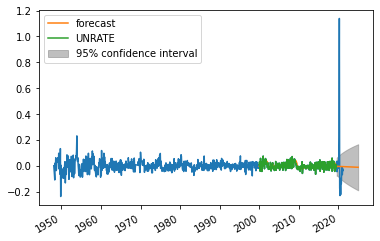

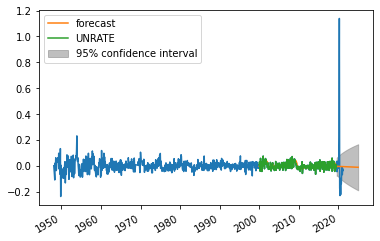

In [25]:
ur_train = ts_diff_exp_ur.iloc[:-20]
ur_test = ts_diff_exp_ur.iloc[-20:]

model = ARIMA(ur_train, order=(6, 2, 2))
res = model.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(ts_diff_exp_ur)

res.plot_predict('2000', '2025', ax=ax)